In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
from sklearn.model_selection import GridSearchCV

In [3]:
data_df = pd.read_csv('star_classification.csv')
data_df.head()

,obj_ID,alpha,delta,u,g,r,i,z,run_ID,rerun_ID,cam_col,field_ID,spec_obj_ID,class,redshift,plate,MJD,fiber_ID
0,1.237661e+18,135.689107,32.494632,23.87882,22.27530,20.39501,19.16573,18.79371,3606,301,2,79,6.543777e+18,GALAXY,0.634794,5812,56354,171
1,1.237665e+18,144.826101,31.274185,24.77759,22.83188,22.58444,21.16812,21.61427,4518,301,5,119,1.176014e+19,GALAXY,0.779136,10445,58158,427
2,1.237661e+18,142.188790,35.582444,25.26307,22.66389,20.60976,19.34857,18.94827,3606,301,2,120,5.152200e+18,GALAXY,0.644195,4576,55592,299
3,1.237663e+18,338.741038,-0.402828,22.13682,23.77656,21.61162,20.50454,19.25010,4192,301,3,214,1.030107e+19,GALAXY,0.932346,9149,58039,775
4,1.237680e+18,345.282593,21.183866,19.43718,17.58028,16.49747,15.97711,15.54461,8102,301,3,137,6.891865e+18,GALAXY,0.116123,6121,56187,842


In [4]:
data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 18 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   obj_ID       100000 non-null  float64
 1   alpha        100000 non-null  float64
 2   delta        100000 non-null  float64
 3   u            100000 non-null  float64
 4   g            100000 non-null  float64
 5   r            100000 non-null  float64
 6   i            100000 non-null  float64
 7   z            100000 non-null  float64
 8   run_ID       100000 non-null  int64  
 9   rerun_ID     100000 non-null  int64  
 10  cam_col      100000 non-null  int64  
 11  field_ID     100000 non-null  int64  
 12  spec_obj_ID  100000 non-null  float64
 13  class        100000 non-null  object 
 14  redshift     100000 non-null  float64
 15  plate        100000 non-null  int64  
 16  MJD          100000 non-null  int64  
 17  fiber_ID     100000 non-null  int64  
dtypes: float64(10), int64(7),

In [5]:
print("The shape of the dataset: {}".format(data_df.shape))

The shape of the dataset: (100000, 18)


In [6]:
labels = data_df['class'].unique()
print(labels)

['GALAXY' 'QSO' 'STAR']


In [7]:
def class_distribution(df, target, classes=labels):
    class_df = df[target].value_counts().to_frame()
    pers = class_df.apply(lambda x: round((x / df.shape[0]) * 100, 2))
    class_df['Percentage'] = pers
    
    plt.figure(figsize=(10, 5))
    plt.subplot(122)
    plt.style.use('tableau-colorblind10')
    bars = sns.barplot(x=class_df.index, y=class_df[target])
    for b in bars.patches:
        x = b.get_x() + (b.get_width() / 2)
        y = b.get_height()
        bars.annotate(text=format(y),
                      xy=(x, y), ha='center', va='center', size=8, 
                      xytext=(0, 6), textcoords='offset points')
    plt.title(label='Class Distribution', fontsize=10)
    
    plt.subplot(121)
    plt.pie(x=class_df['Percentage'].values,
            labels=labels,
            autopct='%.2f')
    plt.title(label='Class Proportion', fontsize=10)
    plt.show()

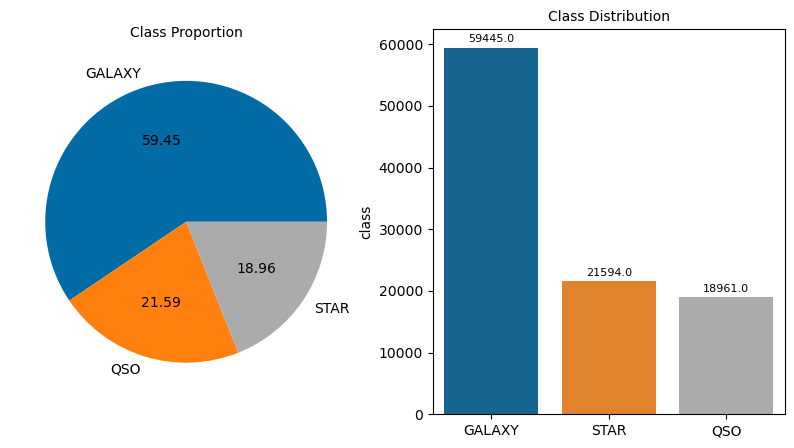

In [8]:
class_distribution(df=data_df, target='class')

In [9]:
display(data_df.isnull().sum())

obj_ID         0
alpha          0
delta          0
u              0
g              0
r              0
i              0
z              0
run_ID         0
rerun_ID       0
cam_col        0
field_ID       0
spec_obj_ID    0
class          0
redshift       0
plate          0
MJD            0
fiber_ID       0
dtype: int64

In [10]:
imp_cols = ['alpha', 'delta', 'u', 'g', 'r', 'i', 'z', 'redshift']

In [11]:
display(data_df[imp_cols].describe().T)

,count,mean,std,min,25%,50%,75%,max
alpha,100000.0,177.629117,96.502241,0.005528,127.518222,180.900700,233.895005,359.999810
delta,100000.0,24.135305,19.644665,-18.785328,5.146771,23.645922,39.901550,83.000519
u,100000.0,21.980468,31.769291,-9999.000000,20.352353,22.179135,23.687440,32.781390
g,100000.0,20.531387,31.750292,-9999.000000,18.965230,21.099835,22.123767,31.602240
r,100000.0,19.645762,1.854760,9.822070,18.135828,20.125290,21.044785,29.571860
i,100000.0,19.084854,1.757895,9.469903,17.732285,19.405145,20.396495,32.141470
z,100000.0,18.668810,31.728152,-9999.000000,17.460677,19.004595,19.921120,29.383740
redshift,100000.0,0.576661,0.730707,-0.009971,0.054517,0.424173,0.704154,7.011245


In [12]:
def box_plotter(df, features, target):
    plt.figure(figsize=(15, 30))
    plt.style.use('tableau-colorblind10')
    for (i, feature) in zip(range(len(features)), features):
        plt.subplot(int('{}2{}'.format(len(features), i+1)))
        sns.boxplot(x=target, y=feature, data=df,
                    width=0.5, flierprops={'marker': 'x'})
        plt.title(label='Boxplot of {}'.format(feature), fontsize=10)
        plt.xlabel(xlabel=None)
        plt.ylabel(ylabel=None)
        i += 1
    plt.show()

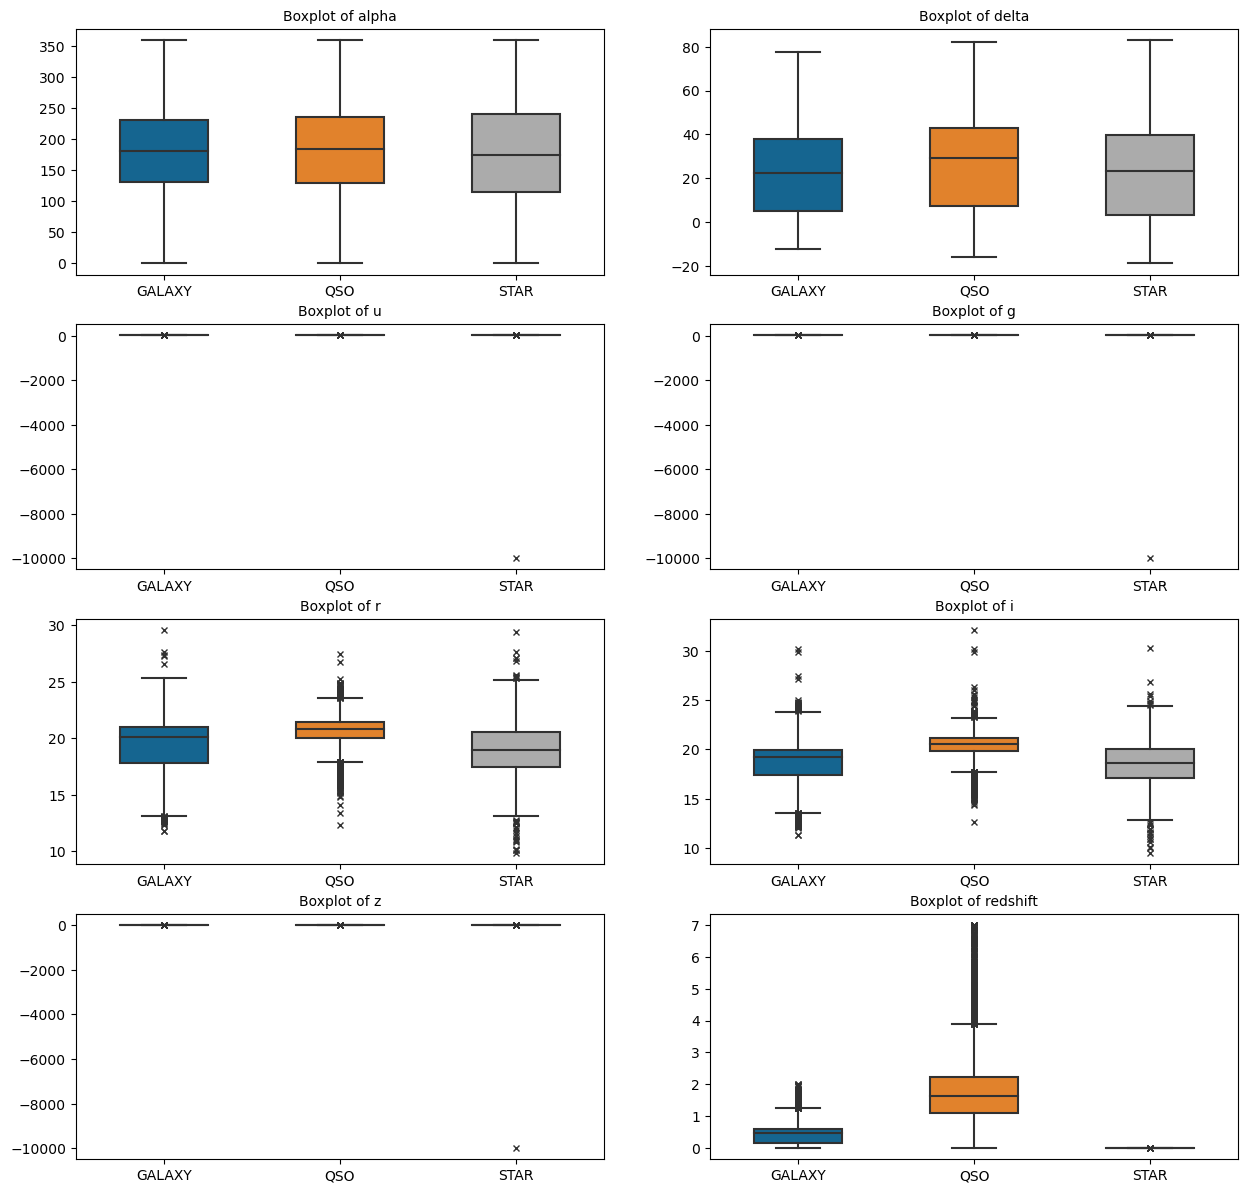

In [13]:
box_plotter(df=data_df, features=imp_cols, target='class')

In [14]:
display(data_df[data_df['u'] == min(data_df['u'])][imp_cols + ['class']])

,alpha,delta,u,g,r,i,z,redshift,class
79543,224.006526,-0.624304,-9999.0,-9999.0,18.1656,18.01675,-9999.0,0.000089,STAR


In [15]:
display(data_df[data_df['g'] == min(data_df['g'])][imp_cols + ['class']])

,alpha,delta,u,g,r,i,z,redshift,class
79543,224.006526,-0.624304,-9999.0,-9999.0,18.1656,18.01675,-9999.0,0.000089,STAR


In [16]:
display(data_df[data_df['z'] == min(data_df['z'])][imp_cols + ['class']])

,alpha,delta,u,g,r,i,z,redshift,class
79543,224.006526,-0.624304,-9999.0,-9999.0,18.1656,18.01675,-9999.0,0.000089,STAR


In [17]:
data_df = data_df.drop(index=[79543])
print("The shape of the dataset: {}".format(data_df.shape))

The shape of the dataset: (99999, 18)


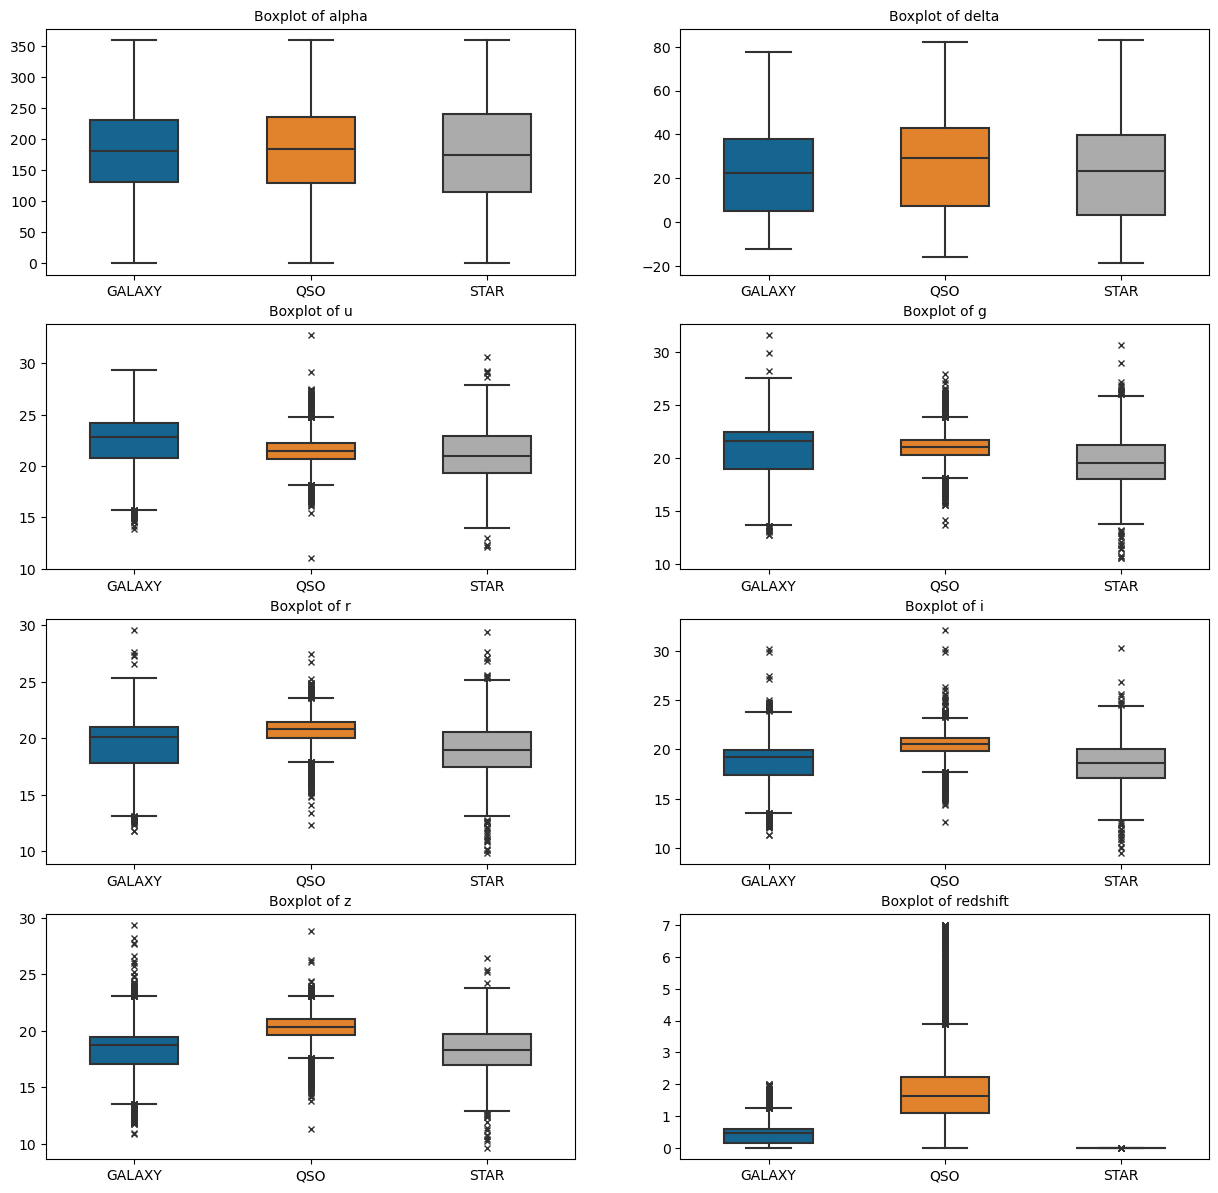

In [18]:
box_plotter(df=data_df, features=imp_cols, target='class')

In [19]:
def pdf_plotter(df, features, target):
    """
    This is funtion helps in plotting the pdf of data.
    
    Parameters
    ----------
    `df`: dataset
    `features`: columns for analysis
    `target`: target column name
    
    Returns none.
    """
    plt.figure(figsize=(15, 30))
    plt.style.use('tableau-colorblind10')
    for (i, feature) in zip(range(len(features)), features):
        plt.subplot(int('{}2{}'.format(len(features), i+1)))
        sns.kdeplot(data=df, x=feature, hue=target, shade=True)
        plt.title(label='PDF of {}'.format(feature), fontsize=10)
        plt.xlabel(xlabel='')
        plt.grid()
        i += 1
    plt.show()

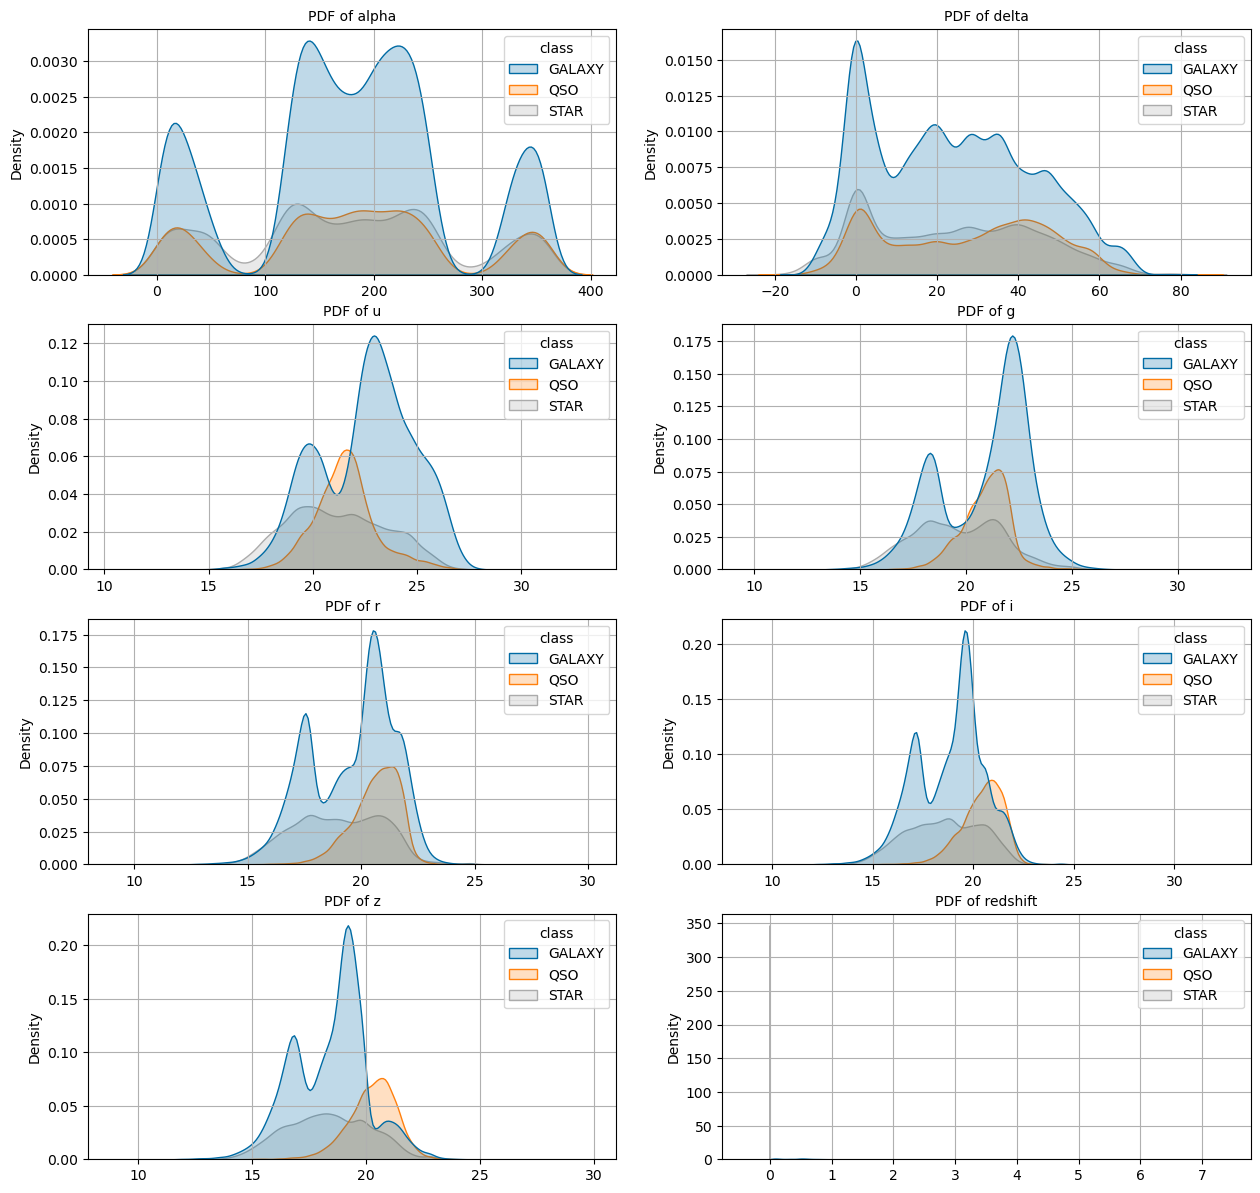

In [20]:
pdf_plotter(df=data_df, features=imp_cols, target='class')

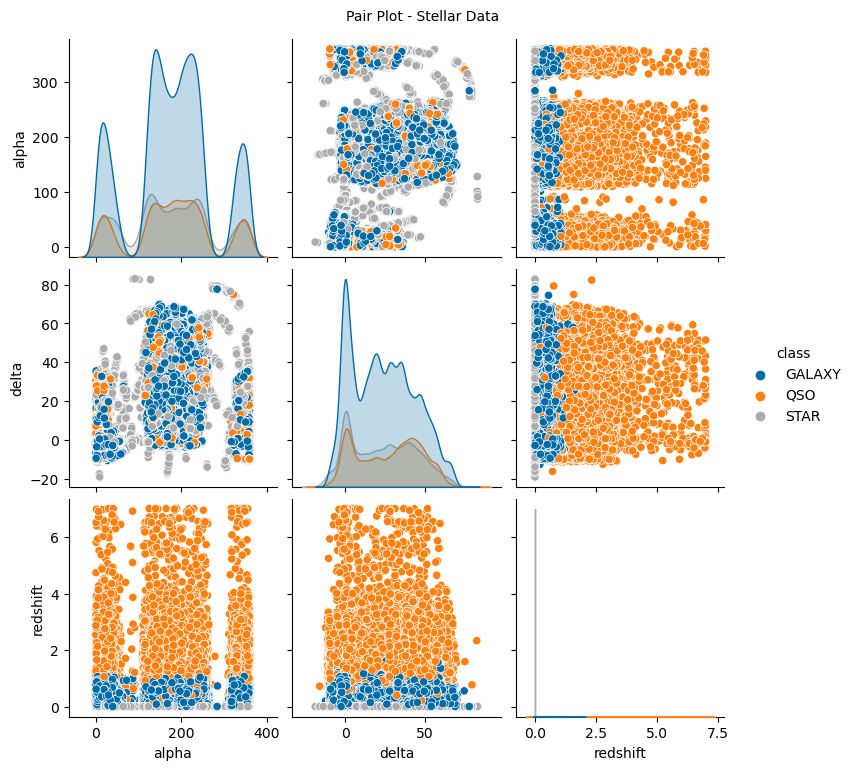

In [21]:
g = sns.pairplot(data=data_df[['alpha', 'delta', 'redshift', 'class']],
                 hue='class')
g.fig.suptitle(t='Pair Plot - Stellar Data', y=1.02, fontsize=10)
plt.show()

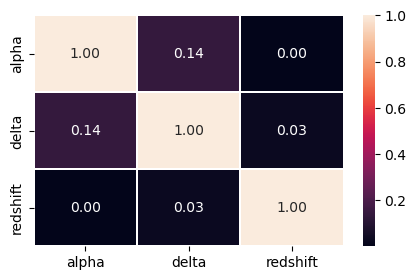

In [22]:
plt.figure(figsize=(5, 3))
sns.heatmap(data=data_df[['alpha', 'delta', 'redshift']].corr(),
            annot=True, fmt='.2f', linewidths=0.1)
plt.show()

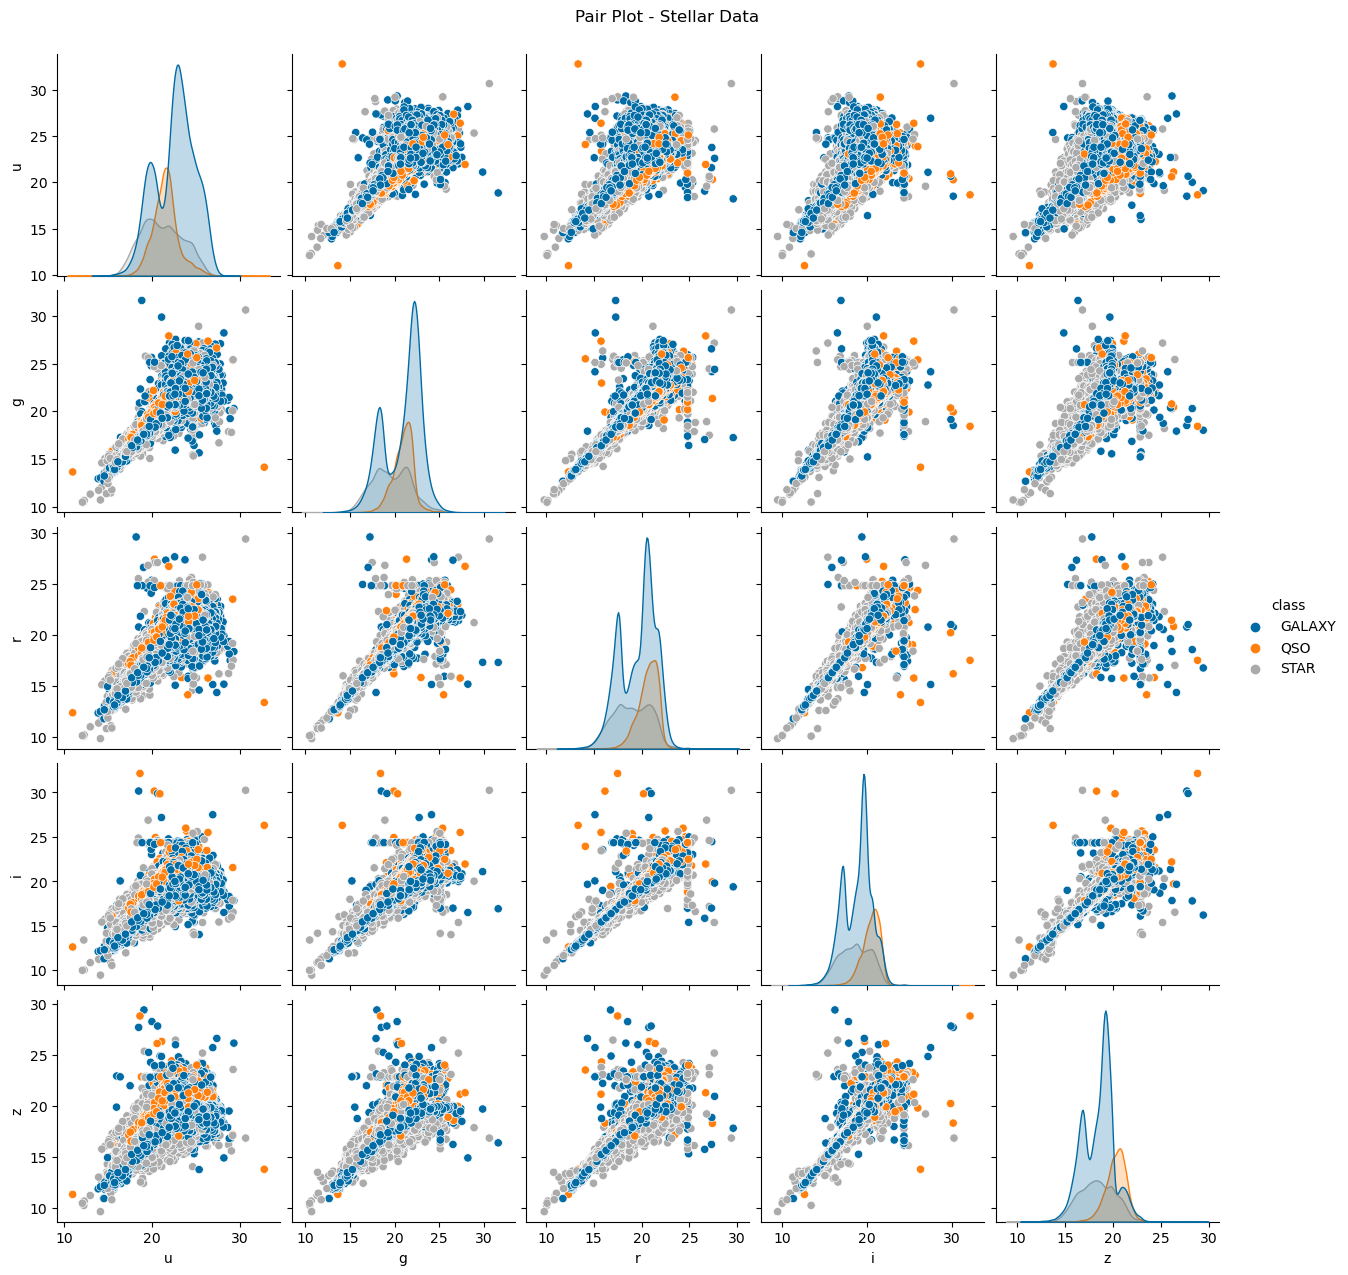

In [22]:
g = sns.pairplot(data=data_df[['u', 'g', 'r', 'i', 'z', 'class']], hue='class')
g.fig.suptitle(t='Pair Plot - Stellar Data', y=1.02)
plt.show()

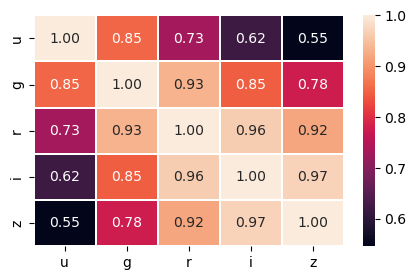

In [23]:
plt.figure(figsize=(5, 3))
sns.heatmap(data=data_df[['u', 'g', 'r', 'i', 'z']].corr(),
            annot=True, fmt='.2f', linewidths=0.1)
plt.show()

In [23]:
data_df.drop(columns=["cam_col"], axis=1, inplace=True)

In [24]:
X = data_df.drop(["class"], axis = 1)
Y = data_df["class"]

In [25]:
#Standardization of data
scaler = StandardScaler()
scaler.fit(X)
scaled_features = scaler.transform(X)

In [26]:
X_standardised = pd.DataFrame(scaled_features,columns=X.columns)
X_standardised.head()

,obj_ID,alpha,delta,u,g,r,i,z,run_ID,rerun_ID,field_ID,spec_obj_ID,redshift,plate,MJD,fiber_ID
0,-0.445658,-0.434597,0.425517,0.798798,0.806782,0.403953,0.046001,0.013999,-0.445559,0.0,-0.718940,0.228602,0.079549,0.228626,0.423198,-1.021353
1,0.018721,-0.339915,0.363391,1.198064,1.079967,1.584395,1.185087,1.611170,0.018627,0.0,-0.450496,1.797901,0.277088,1.797912,1.420719,-0.081893
2,-0.445658,-0.367244,0.582702,1.413732,0.997513,0.519736,0.150012,0.101520,-0.445559,0.0,-0.443785,-0.190042,0.092415,-0.190031,0.001850,-0.551623
3,-0.147332,1.669522,-1.249122,0.024940,1.543642,1.059894,0.807601,0.272435,-0.147299,0.0,0.187058,1.358952,0.486761,1.358932,1.354918,1.195186
4,1.842773,1.737308,-0.150255,-1.174337,-1.497665,-1.697426,-1.767888,-1.825836,1.842797,0.0,-0.329696,0.333321,-0.630273,0.333290,0.330855,1.441060


In [27]:
#data split in training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_standardised,Y,test_size=0.30)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdim

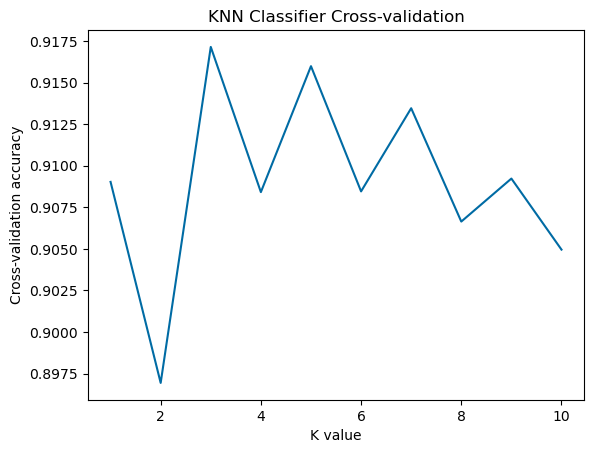

In [29]:
from sklearn.model_selection import cross_val_score

# Create a list of K values to try
k_values = list(range(1, 11))

# Initialize an empty list to store the cross-validation scores
cv_scores = []

# Perform cross-validation for each value of K
for k in k_values:
    knn = KNeighborsClassifier(n_neighbors=k)
    scores = cross_val_score(knn, X_train, y_train, cv=5)  # Use 5-fold cross-validation
    cv_scores.append(np.mean(scores))

# Plot the cross-validation scores for each value of K
plt.plot(k_values, cv_scores)
plt.xlabel('K value')
plt.ylabel('Cross-validation accuracy')
plt.title('KNN Classifier Cross-validation')
plt.show()

In [28]:
#KNN Classifier
knn = KNeighborsClassifier(n_neighbors=3)

knn.fit(X_train,y_train)
pred = knn.predict(X_test)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


<AxesSubplot:>

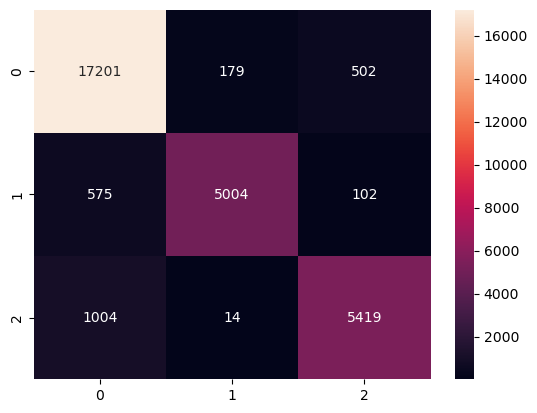

In [29]:
sns.heatmap(confusion_matrix(y_test,pred), annot=True, fmt='g')

In [30]:
#Accuracy scores for KNN
print(classification_report(y_test,pred))

              precision    recall  f1-score   support

      GALAXY       0.92      0.96      0.94     17882
         QSO       0.96      0.88      0.92      5681
        STAR       0.90      0.84      0.87      6437

    accuracy                           0.92     30000
   macro avg       0.93      0.89      0.91     30000
weighted avg       0.92      0.92      0.92     30000



In [33]:
parameters = {'criterion':["gini", "entropy", "log_loss"],
           'splitter':["best", "random"],
 
           }

In [34]:
clf_entropy=DecisionTreeClassifier()
cv=GridSearchCV(clf_entropy,param_grid=parameters,cv=5,scoring='accuracy')

In [35]:
cv.fit(X_train,y_train)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
10 fits failed out of a total of 30.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
10 fits failed with the following error:
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\tree\_classes.py", line 937, in fit
    super().fit(
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\tree\_classes.py", line 352, in fit
    criterion = CRITERIA_CLF[self.criterion](
KeyError: 'log_loss'

  warnings.warn(some_fits_failed_me

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(),
             param_grid={'criterion': ['gini', 'entropy', 'log_loss'],
                         'splitter': ['best', 'random']},
             scoring='accuracy')

In [36]:
cv.best_params_

{'criterion': 'entropy', 'splitter': 'best'}

<AxesSubplot:>

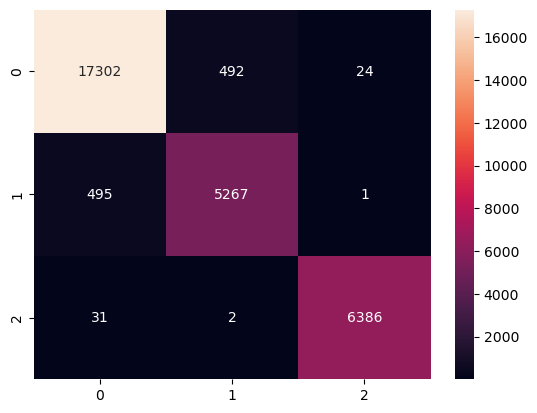

In [37]:
clf_entropy=DecisionTreeClassifier(criterion='entropy',
 splitter= 'best')
clf_entropy.fit(X_train,y_train)
pred = clf_entropy.predict(X_test)
sns.heatmap(confusion_matrix(y_test,pred), annot=True, fmt='g')

In [38]:
print(classification_report(y_test,pred))

              precision    recall  f1-score   support

      GALAXY       0.97      0.97      0.97     17818
         QSO       0.91      0.91      0.91      5763
        STAR       1.00      0.99      1.00      6419

    accuracy                           0.97     30000
   macro avg       0.96      0.96      0.96     30000
weighted avg       0.97      0.97      0.97     30000



[Text(0.37972150351386325, 0.9821428571428571, 'X[12] <= -0.783\nentropy = 1.378\nsamples = 69999\nvalue = [41627, 13198, 15174]'),
 Text(0.02973170356703567, 0.9464285714285714, 'X[12] <= -0.789\nentropy = 0.163\nsamples = 15542\nvalue = [366, 2, 15174]'),
 Text(0.008943214432144322, 0.9107142857142857, 'X[12] <= -0.791\nentropy = 0.03\nsamples = 9629\nvalue = [29, 0, 9600]'),
 Text(0.0024600246002460025, 0.875, 'X[12] <= -0.795\nentropy = 0.569\nsamples = 67\nvalue = [9, 0, 58]'),
 Text(0.0016400164001640015, 0.8392857142857143, 'entropy = 0.0\nsamples = 4\nvalue = [4, 0, 0]'),
 Text(0.003280032800328003, 0.8392857142857143, 'X[4] <= 2.334\nentropy = 0.4\nsamples = 63\nvalue = [5, 0, 58]'),
 Text(0.0016400164001640015, 0.8035714285714286, 'X[1] <= -1.716\nentropy = 0.286\nsamples = 60\nvalue = [3, 0, 57]'),
 Text(0.0008200082000820008, 0.7678571428571429, 'entropy = 0.0\nsamples = 1\nvalue = [1, 0, 0]'),
 Text(0.0024600246002460025, 0.7678571428571429, 'X[12] <= -0.794\nentropy = 0.2

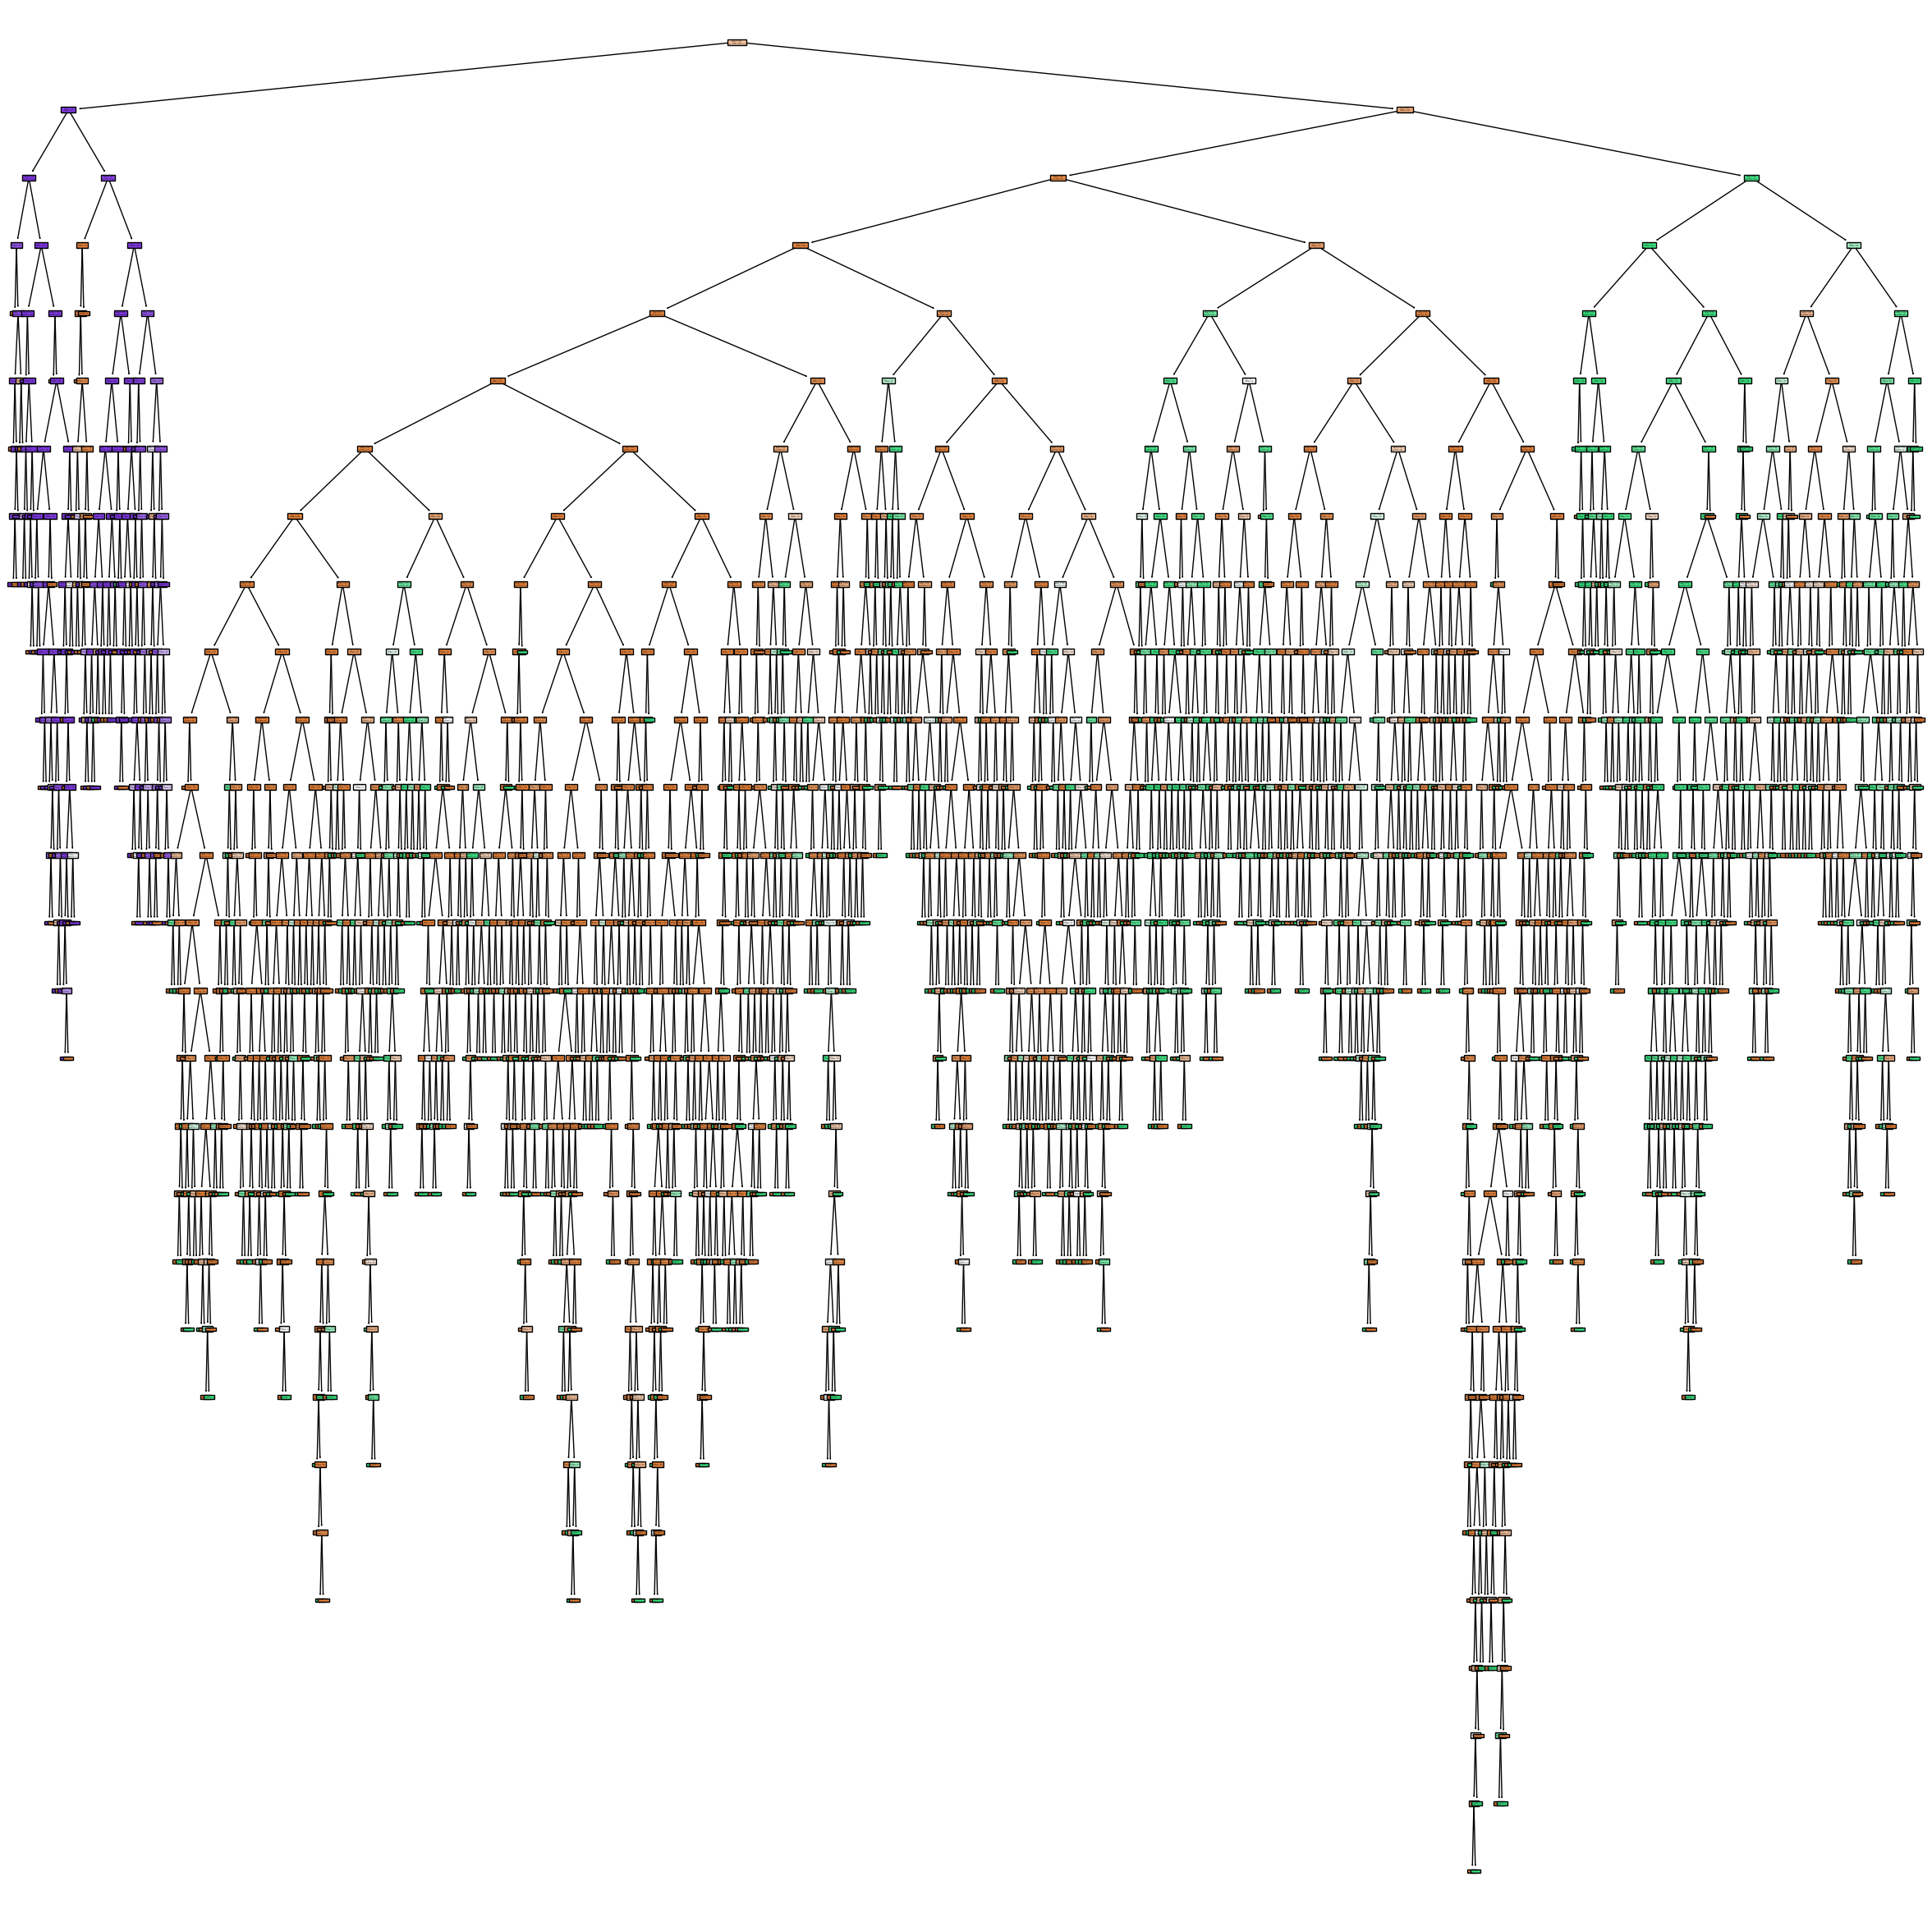

In [39]:
plt.figure(figsize=(30,30))
tree.plot_tree(clf_entropy,filled=True)

In [37]:
from sklearn.ensemble import RandomForestClassifier 
from sklearn.model_selection import GridSearchCV
clf_randomforest= RandomForestClassifier()  
parameters = {'n_estimators':[100,150,200,300]}
cv_rf=GridSearchCV(clf_randomforest,param_grid=parameters,cv=5,scoring='accuracy')
cv_rf.fit(X_train,y_train)

GridSearchCV(cv=5, estimator=RandomForestClassifier(),
             param_grid={'n_estimators': [100, 150, 200, 300]},
             scoring='accuracy')

In [38]:
cv_rf.best_params_

{'n_estimators': 100}

<AxesSubplot:>

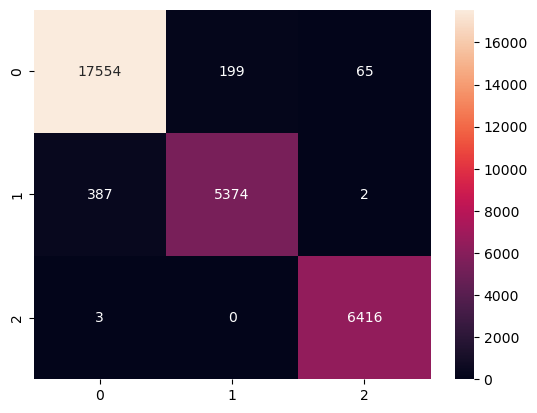

In [82]:
clf_randomforest= RandomForestClassifier(n_estimators=100) 
clf_randomforest.fit(X_train, y_train)  
pred = clf_randomforest.predict(X_test)
sns.heatmap(confusion_matrix(y_test,pred), annot=True, fmt='g')

In [83]:
print(classification_report(y_test,pred))

              precision    recall  f1-score   support

      GALAXY       0.98      0.99      0.98     17818
         QSO       0.96      0.93      0.95      5763
        STAR       0.99      1.00      0.99      6419

    accuracy                           0.98     30000
   macro avg       0.98      0.97      0.97     30000
weighted avg       0.98      0.98      0.98     30000



In [88]:
from sklearn.ensemble import GradientBoostingClassifier
clf_boosting= GradientBoostingClassifier()  
parameters = {'n_estimators':[100,150,200,300]}
cv_xgb=GridSearchCV(clf_boosting,param_grid=parameters,cv=5,scoring='accuracy')
cv_xgb.fit(X_train,y_train)

GridSearchCV(cv=5, estimator=GradientBoostingClassifier(),
             param_grid={'n_estimators': [100, 150, 200, 300]},
             scoring='accuracy')

In [89]:
cv_xgb.best_params_

{'n_estimators': 300}

<AxesSubplot:>

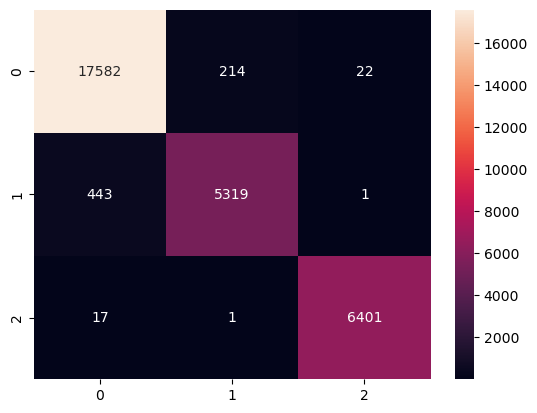

In [90]:
clf_boosting = GradientBoostingClassifier(n_estimators=300).fit(X_train, y_train)
pred = clf_boosting.predict(X_test)
sns.heatmap(confusion_matrix(y_test,pred), annot=True, fmt='g')

In [91]:
print(classification_report(y_test,pred))

              precision    recall  f1-score   support

      GALAXY       0.97      0.99      0.98     17818
         QSO       0.96      0.92      0.94      5763
        STAR       1.00      1.00      1.00      6419

    accuracy                           0.98     30000
   macro avg       0.98      0.97      0.97     30000
weighted avg       0.98      0.98      0.98     30000



In [96]:
from sklearn.linear_model import LogisticRegression
#create a new logistic regression model
log_reg = LogisticRegression()
# Creating the hyperparameter grid
c_space = np.logspace(-5, 8, 15)
param_grid = {'C': c_space}
# Instantiating the GridSearchCV object
log_reg_cv = GridSearchCV(log_reg, param_grid, cv = 5)
 
log_reg_cv.fit(X_train, y_train)
log_reg_cv.best_params_

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

{'C': 163789.3706954068}

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


<AxesSubplot:>

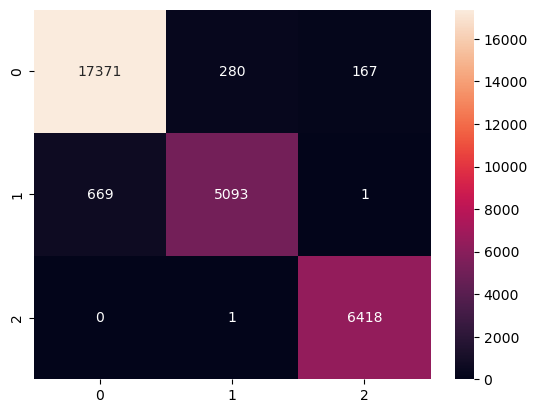

In [98]:
log_reg = LogisticRegression(C=163789.3706954068)
log_reg.fit(X_train, y_train)
pred = log_reg.predict(X_test)
sns.heatmap(confusion_matrix(y_test,pred), annot=True, fmt='g')

In [99]:
print(classification_report(y_test,pred))

              precision    recall  f1-score   support

      GALAXY       0.96      0.97      0.97     17818
         QSO       0.95      0.88      0.91      5763
        STAR       0.97      1.00      0.99      6419

    accuracy                           0.96     30000
   macro avg       0.96      0.95      0.96     30000
weighted avg       0.96      0.96      0.96     30000



In [102]:
from sklearn.ensemble import VotingClassifier
#create a dictionary of our models
estimators=[('logistic_regression', log_reg), ('rf', clf_randomforest), ('XGBOOST', clf_boosting)]
#create our voting classifier, inputting our models
ensemble = VotingClassifier(estimators, voting='hard')

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


<AxesSubplot:>

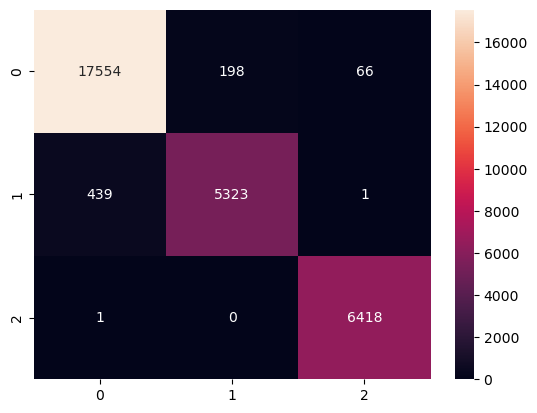

In [104]:
#fit model to training data
ensemble.fit(X_train, y_train)
#test our model on the test data
pred = ensemble.predict(X_test)
sns.heatmap(confusion_matrix(y_test,pred), annot=True, fmt='g')

In [105]:
print(classification_report(y_test,pred))

              precision    recall  f1-score   support

      GALAXY       0.98      0.99      0.98     17818
         QSO       0.96      0.92      0.94      5763
        STAR       0.99      1.00      0.99      6419

    accuracy                           0.98     30000
   macro avg       0.98      0.97      0.97     30000
weighted avg       0.98      0.98      0.98     30000

